# Important Links/Data

In [1]:
#https://nomads.ncep.noaa.gov/pub/data/nccf/com/cfs/prod/
#https://nomads.ncep.noaa.gov/pub/data/nccf/com/cfs/prod/cfs/cfs.20191022/00/6hrly_grib_01/pgbf2019102800.01.2019102200.grb2   

# Load Python Packages

In [2]:
import os
import wget
import xarray as xr

import datetime
from datetime import timedelta

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
import numpy as np

# Local Paths

In [3]:
LocalPath_CFS_Input= "/Users/chelseasnide/Desktop/Data/Input/CFS"
LocalPath_CFS_Output= "/Users/chelseasnide/Desktop/Data/Output/CFS"

# Forecast Inputs

In [4]:
ModelType='CFS'
MarkDate='20191215'
ForecastHour='24'
ModelHourInit='00'    #  00,06,12,18
Resolution='1p00'     #  0p25, 0p50, 1p00   
Ensemble_Number='01'  # 01, 02, 03, or 04

format_str = '%Y%m%d' # The format
ForecastDate = datetime.datetime.strptime(MarkDate, format_str) + timedelta(hours=int(ForecastHour))
ForecastDate=ForecastDate.strftime("%Y%m%d")

print(MarkDate)
print(ForecastDate)

20191215
20191216


# Delete Old Files

In [5]:
### Delete files to conserve space on the Google Cloud
try:
    os.system("rm -rf /Users/chelseasnide/Desktop/Data/Input/CFS*.grib")
    print("File Deleted")
except OSError:
    print("File does not exist")

File Deleted


# Load Data

In [6]:
url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/cfs/prod/cfs/cfs.' + str(MarkDate) + '/' + \
ModelHourInit + '/6hrly_grib_' + Ensemble_Number + '/pgbf' + ForecastDate + ModelHourInit + '.' + Ensemble_Number + '.' + MarkDate + ModelHourInit + '.grb2'

wget.download(url, LocalPath_CFS_Input + str(ModelHourInit) + 'Z' + ModelType + '_' + str(MarkDate) + '_' + str(ForecastDate) + '_' + str(Resolution) + '_' + Ensemble_Number + ".grib") 
ds=xr.open_dataset(LocalPath_CFS_Input + str(ModelHourInit) + 'Z' + ModelType + '_' + str(MarkDate) + '_' + str(ForecastDate) + '_' + str(Resolution) + '_' + Ensemble_Number + '.grib',engine='pynio')

# Create a clean datetime object for plotting

In [7]:
format_str = '%Y%m%d' # The format
MarkDate_Coded = datetime.datetime.strptime(MarkDate, format_str)
MarkDateOnMaps=MarkDate_Coded.strftime("%a %d %b %Y")
itime= ModelHourInit + 'Z ' + str(MarkDateOnMaps)

format_str = '%HZ %a %d %b %Y' # The format
vtime = datetime.datetime.strptime(itime, format_str) + timedelta(hours=int(ForecastHour))
vtime = vtime.strftime("%HZ %a %d %b %Y")

# Render 500 Heights/SLP Map

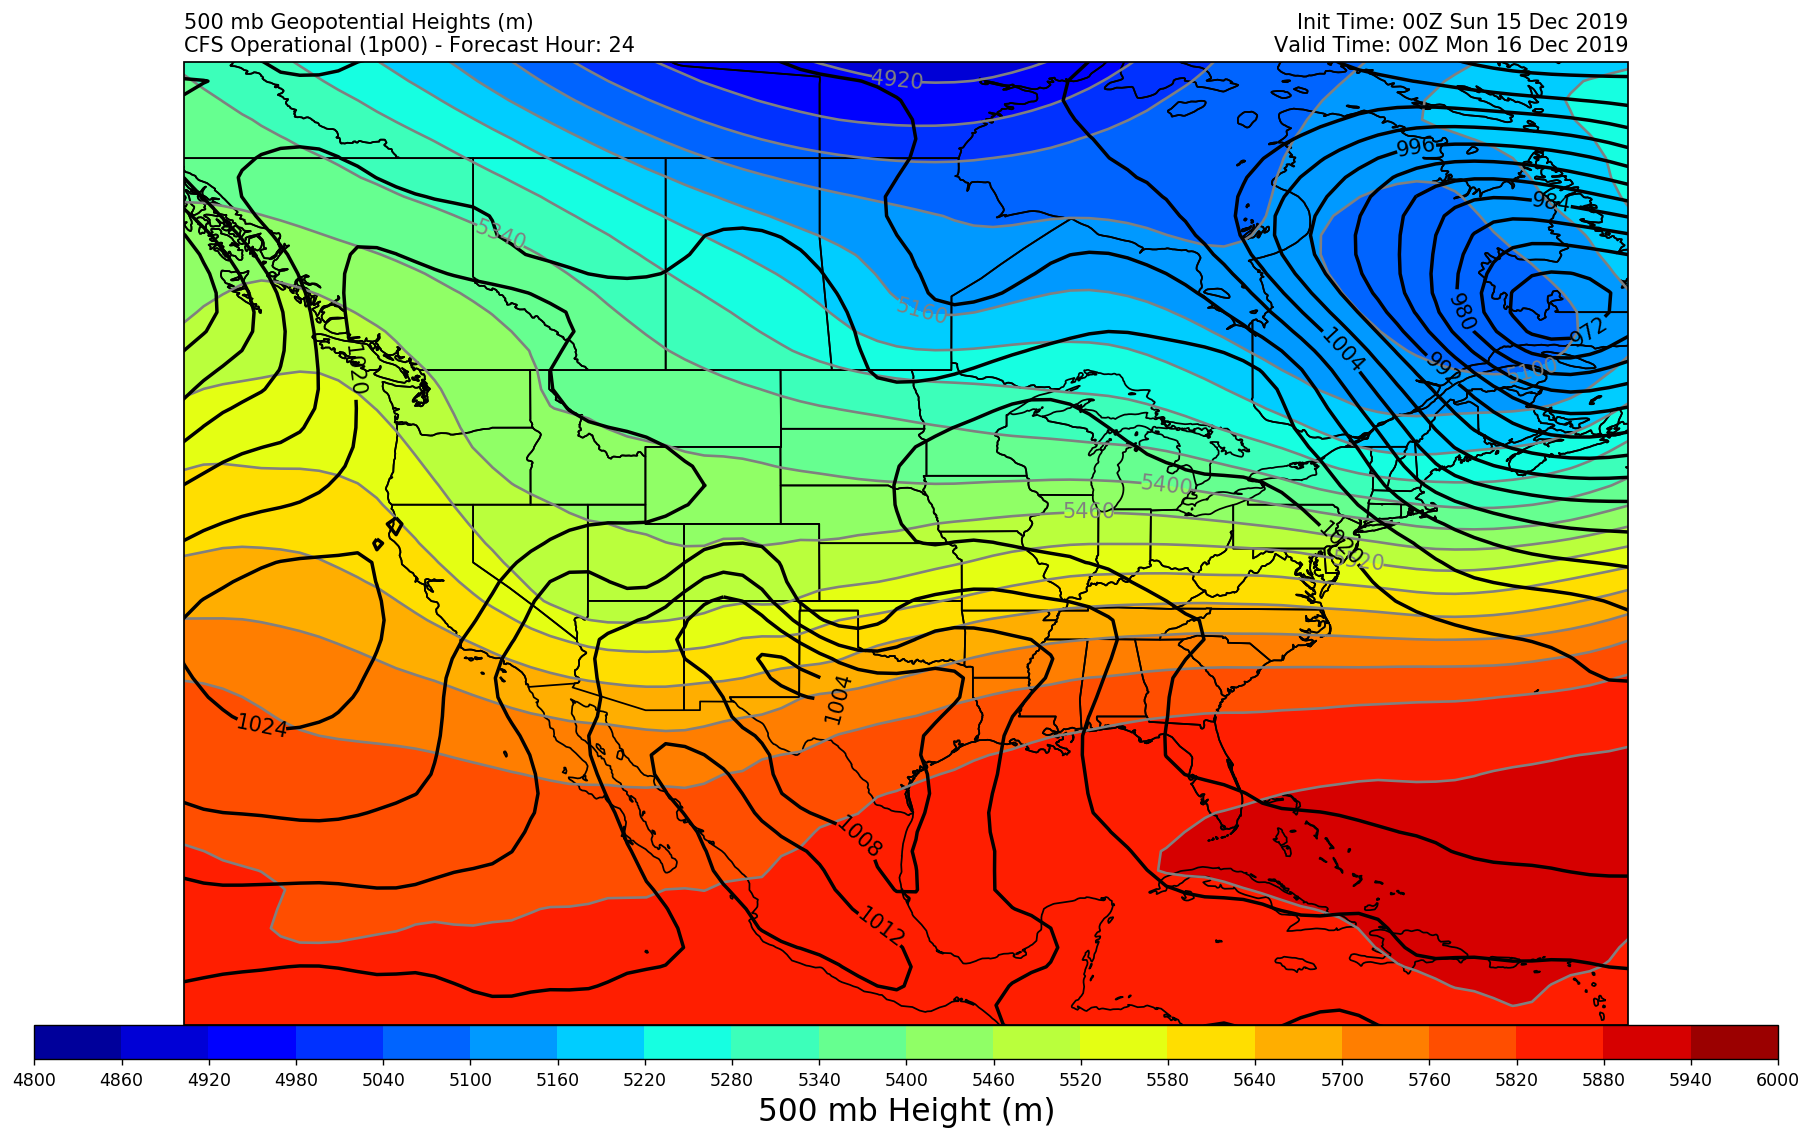

In [18]:
ds.coords
lats = ds.lat_0.data
lons = ds.lon_0.data

### Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()
mapcrs= ccrs.Miller() ## Good
mapcrs= ccrs.PlateCarree() ## Good

### Start the figure and create plot axes with proper projection
fig = plt.figure(figsize=(18,12),dpi=125, facecolor='white')

ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-135, -60, 15, 65], ccrs.PlateCarree())

### Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

### Select and grab data
hght=ds['HGT_P0_L100_GLL0']

### Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_500 = gaussian_filter(hght.sel(lv_ISBL0=50000), sigma=0.0)

### Plot 500-hPa Colorfill Heights in meters (m)
clevs_500_hght = np.arange(4800, 6060, 60)
cf = ax.contourf(lons, lats, hght_500, clevs_500_hght, cmap='jet',transform=datacrs)
cb=plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, shrink=1,label='Wave Height (m)', ticks=clevs_500_hght)
cb.set_label(label='500 mb Height (m)',size=18, color='black')

params = {"text.color" : "black",
          "xtick.color" : "black",
          "ytick.color" : "black"}
plt.rcParams.update(params)

### Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(4800, 6000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='grey',transform=datacrs)
plt.clabel(cs, inline=True, fontsize=12, fmt='%d')

# Grab MSLP and smooth, use MetPy Units module for conversion
mslp = (ds['PRMSL_P0_L101_GLL0'][:])/100  # Convert to hPa

# Plot MSLP
clevmslp = np.arange(940., 1060., 4)
cs2 = ax.contour(lons, lats, mslp, clevmslp, colors='k', linewidths=2.00,linestyles='solid', transform=datacrs)

kw_clabels = {'fontsize': 12, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

plt.clabel(cs2, **kw_clabels)
   
##################################################################
# Make some nice titles for the plot (one right, one left) #######
##################################################################
plt.title('500 mb Geopotential Heights (m) \nCFS Operational ('+ Resolution +') - Forecast Hour: ' + str(ForecastHour), loc='left', color='black')
plt.title('Init Time: {}'.format(itime) + '\nValid Time: {}'.format(vtime), loc='right', color='black')

##################################################################
# Save Image #####################################################
##################################################################
plt.savefig(LocalPath_CFS_Output + 'CFS_500_SLP.png', bbox_inches='tight', facecolor='white')